# Welcome to the Object Recognition in Python Notebook!

This module is part of the set of scripts within object_recognition_in_python. This notebook was released by J.R. Ruiz-Sarmiento, and is publicly available at:

https://github.com/jotaraul/object_recognition_in_python

under the GNUv3 license. Their goal is to show some directions for the utilization of tools writen in Python, like pandas, seaborn or scikit-learn, for the design of object recognition systems.
    
Hope you enjoy the experience and, above all, learn ;)

First, we will start loading the needed Python modules:


In [1]:
import matplotlib.pyplot as plt
# General imports
import numpy as np
# For managing and ploting data
import pandas
import scipy
import seaborn
import time
from bisect import bisect
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# scikit-learn imports
from sklearn import svm
from sklearn import tree
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Tutorial imports
import scripts.utils_notebook as utils

Now we are going to configure different options like the dataset, the features (variables) to work with, etc.



In [2]:
config = {}

# [GENERAL CONFIGURATION]

config["dataset_file"] = './datasets/robot_at_home.csv'
config["balance_dataset"] = True
config["vbles_to_work_with"] = [ 'PLANARITY','SCATTER','LINEARITY','MINHEIGHT','MAXHEIGHT','CENTROID_X','CENTROID_Y','CENTROID_Z',
                       'VOLUME','BIGGESTAREA','ORIENTATION','HUEMEAN','SATMEAN','VALMEAN','HUESTDV','SATSTDV','VALSTDV',
                       'HUEHIST0','HUEHIST1','HUEHIST2','HUEHIST3','HUEHIST4','VALHIST0','VALHIST1','VALHIST2',
                       'VALHIST3','VALHIST4','SATHIST0','SATHIST1','SATHIST2','SATHIST3','SATHIST4' ]
config["gt_vble"] = 'OBJECTCATEGORY'
config["n_object_categories"] = 15

# [DESCRIPTIVE ANALYSIS CONFIGURATION]

config["graphical_representation"] = 'boxplot'
config["n_discrete_values"] = 2

# [PRE-PROCESSING CONFIGURATION]

config["standarized_features"] = True

# [MODEL TESTING CONFIGURATION]

config["models_to_work_with"] = ['Logistic','SVM','KNeighbors','DecisionTree','RandomForest','ExtraTrees','GaussianNaiveBayes']
config["cross_validation_n_iterations"] = 10
config["cross_validation_n_folds"] = 4
config["show_confuion_matrix"] = False
config["confusion_matrix_show_method"] = 'RandomForest'

# [VISUALIZATION OPTIONS]
#title_font = {'fontname': 'Arial', 'size': '21', 'color': 'black', 'weight': 'normal', 'verticalalignment': 'bottom'}
config["title_font"] = {'size': '21', 'color': 'black', 'weight': 'normal', 'verticalalignment': 'bottom'}
#axis_font = {'fontname': 'Arial', 'size': '20'}
config["axis_font"] = {'size': '20'}
config["ticks_size"] = 20

## First step: data managament and analysis

Now, we load the dataset containing characterized objects and perform some analyses.

In [3]:
# Let's go! Load the dataset
data = pandas.read_csv(config["dataset_file"], low_memory=False)

# print some information about the dataset
print "[Working the the '" + config["dataset_file"].split('/')[-1] + "' dataset!]"
print "Info: "
print "Number of observations within the dataset: " + str(len(data))  # number of observations (rows)
print "Number of variables                      : " + str(len(data.columns))  # number of variables (columns)

# upper-case all DataFrame column names
data.columns = map(str.upper, data.columns)

for vble in config["vbles_to_work_with"]:
    # setting variables you will be working with to numeric
    data[vble] = pandas.to_numeric(data[vble], errors="coerce")

# And the ground truth one to categorical
data[config["gt_vble"]] = data[config["gt_vble"]].astype('category')

# Get entries corresponding with the selected object categories (config["n_object_categories"] most appearing)
sub_data = pandas.value_counts(data[config["gt_vble"]], sort=True)
print "Number of observations with values       : " + str(np.sum(sub_data))
print 'Number of different categories           : ' + str(sub_data.size)
print "\nNumber of objects per category in the dataset:"
print sub_data
data = data[data['OBJECTCATEGORY'].isin(sub_data.index[0:config["n_object_categories"]])]
data['OBJECTCATEGORY'] = data['OBJECTCATEGORY'].cat.remove_unused_categories()
#data[config["gt_vble"] = data[config["gt_vble"].replace({'upper_cabinet': 'ucabinet'}) # only for Robot@Home dataset

[Working the the 'robot_at_home.csv' dataset!]
Info: 
Number of observations within the dataset: 2309
Number of variables                      : 36
Number of observations with values       : 2309
Number of different categories           : 180

Number of objects per category in the dataset:
wall                          344
picture                       165
bottle                        117
door                           90
chair                          76
floor                          70
table                          59
shelf                          57
cushion                        56
cabinet                        55
shelves                        52
ceiling                        47
upper_cabinet                  46
lamp                           43
faucet                         38
curtain                        37
window                         32
closet                         31
pen_holder                     30
paper_roll                     29
couch                        

Graphically show the instances distribution in the dataset:

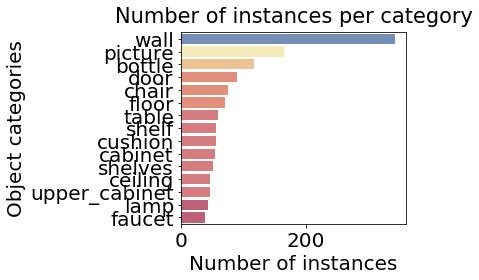

In [4]:
# VISUALIZATION 
# Visually show the most appearing categories
utils.plot_instances_distribution(data, config)

In [5]:
if config["balance_dataset"]:
    g = data.groupby('OBJECTCATEGORY')
    data = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)

    c2 = pandas.value_counts(data[config["gt_vble"]], sort=True)
    print "Number of observations with values: " + str(np.sum(c2))
    print c2
    data = data[data['OBJECTCATEGORY'].isin(c2.index[0:config["n_object_categories"]])]
    data['OBJECTCATEGORY'] = data['OBJECTCATEGORY'].cat.remove_unused_categories()

Number of observations with values: 570
wall             38
upper_cabinet    38
table            38
shelves          38
shelf            38
picture          38
lamp             38
floor            38
faucet           38
door             38
cushion          38
chair            38
ceiling          38
cabinet          38
bottle           38
Name: OBJECTCATEGORY, dtype: int64


In [6]:
# Describe predictors
for vble in config["vbles_to_work_with"]:
    print data[vble].describe()

count    570.000000
mean       0.194742
std        0.113897
min        0.000721
25%        0.103592
50%        0.173554
75%        0.274159
max        0.486462
Name: PLANARITY, dtype: float64
count    570.000000
mean       0.722554
std        0.131578
min        0.402842
25%        0.614512
50%        0.724400
75%        0.833526
max        0.997626
Name: SCATTER, dtype: float64
count    570.000000
mean       0.486461
std        0.240845
min        0.012971
25%        0.293240
50%        0.493156
75%        0.688503
max        0.996079
Name: LINEARITY, dtype: float64
count    570.000000
mean       0.625598
std        0.633625
min       -0.249461
25%        0.015475
50%        0.480250
75%        1.080008
max        2.373020
Name: MINHEIGHT, dtype: float64
count    570.000000
mean       1.247968
std        0.658726
min       -0.012844
25%        0.742212
50%        1.102155
75%        1.869210
max        2.615570
Name: MAXHEIGHT, dtype: float64
count    570.000000
mean       0.629791
st

bottle
6
cabinet
9
ceiling
9
chair
7
cushion
14
door
10
faucet
7
floor
8
lamp
7
picture
14
shelf
5
shelves
9
table
7
upper_cabinet
7
wall
8
{'picture': (0.7114186851211075, 0.8832756632064592, 0.6348327566320646), 'ceiling': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'door': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'bottle': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'floor': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'wall': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'shelf': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'shelves': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'faucet': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'cabinet': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'upper_cabinet': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'lamp': (0.9946943483275663, 0.8092272202998846, 0.4869665513

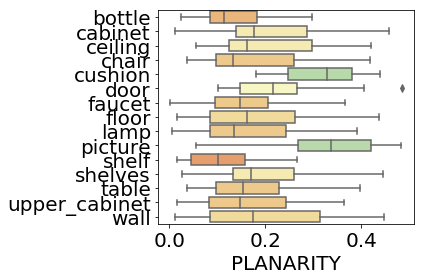

bottle
11
cabinet
12
ceiling
13
chair
9
cushion
7
door
13
faucet
10
floor
15
lamp
9
picture
8
shelf
16
shelves
10
table
12
upper_cabinet
12
wall
14
{'picture': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'ceiling': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'door': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'bottle': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'floor': (0.5910034602076126, 0.835524798154556, 0.6442906574394464), 'wall': (0.7114186851211075, 0.8832756632064592, 0.6348327566320646), 'shelf': (0.47427912341407163, 0.7898500576701268, 0.6459823144944252), 'shelves': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'faucet': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'cabinet': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'upper_cabinet': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'lamp': (0.9982314494425221, 0.9451749327181853, 0.65705

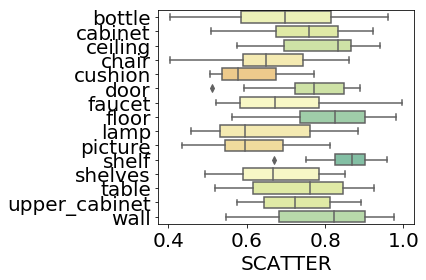

bottle
10
cabinet
10
ceiling
12
chair
8
cushion
5
door
11
faucet
10
floor
13
lamp
8
picture
5
shelf
15
shelves
9
table
11
upper_cabinet
11
wall
12
{'picture': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'ceiling': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'door': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'bottle': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'floor': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'wall': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'shelf': (0.5910034602076126, 0.835524798154556, 0.6442906574394464), 'shelves': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'faucet': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'cabinet': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'upper_cabinet': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'lamp': (0.9963860053825452, 0.8879661668589004, 0.56109188

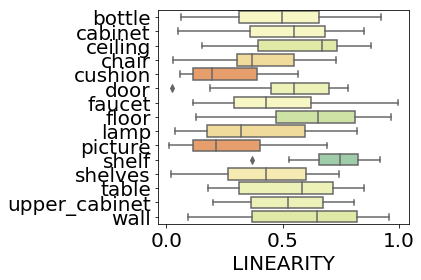

bottle
8
cabinet
3
ceiling
18
chair
4
cushion
6
door
3
faucet
8
floor
2
lamp
7
picture
12
shelf
12
shelves
5
table
4
upper_cabinet
12
wall
4
{'picture': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'ceiling': (0.26405228758169935, 0.6091503267973857, 0.7098039215686275), 'door': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'bottle': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'floor': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'wall': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'shelf': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'shelves': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'faucet': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'cabinet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'upper_cabinet': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'lamp': (0.9946943483275663, 0.8092272202998846, 0.486966

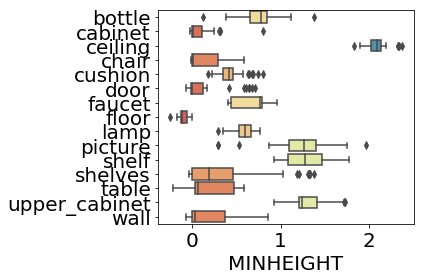

bottle
8
cabinet
8
ceiling
18
chair
8
cushion
6
door
14
faucet
7
floor
1
lamp
8
picture
13
shelf
11
shelves
13
table
5
upper_cabinet
16
wall
16
{'picture': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'ceiling': (0.26405228758169935, 0.6091503267973857, 0.7098039215686275), 'door': (0.7114186851211075, 0.8832756632064592, 0.6348327566320646), 'bottle': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'floor': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'wall': (0.47427912341407163, 0.7898500576701268, 0.6459823144944252), 'shelf': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'shelves': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'faucet': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'cabinet': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'upper_cabinet': (0.47427912341407163, 0.7898500576701268, 0.6459823144944252), 'lamp': (0.9963860053825452, 0.8879661668589004, 0.561

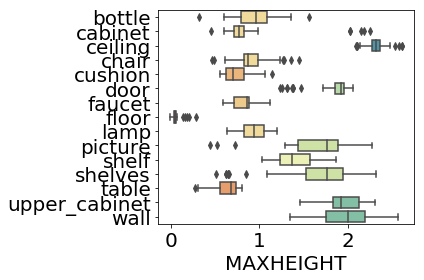

bottle
11
cabinet
10
ceiling
12
chair
9
cushion
11
door
11
faucet
12
floor
11
lamp
11
picture
10
shelf
11
shelves
11
table
10
upper_cabinet
11
wall
12
{'picture': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'ceiling': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'door': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'bottle': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'floor': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'wall': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'shelf': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'shelves': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'faucet': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'cabinet': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'upper_cabinet': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'lamp': (0.9557862360630527, 0.9823144944252211, 0.68

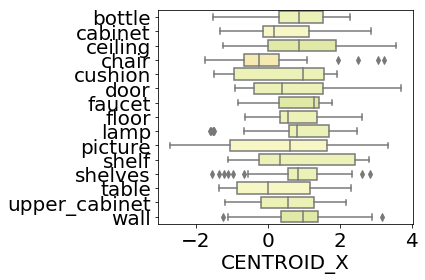

bottle
8
cabinet
6
ceiling
18
chair
6
cushion
6
door
9
faucet
7
floor
1
lamp
7
picture
12
shelf
12
shelves
9
table
5
upper_cabinet
13
wall
10
{'picture': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'ceiling': (0.26405228758169935, 0.6091503267973857, 0.7098039215686275), 'door': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'bottle': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'floor': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'wall': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'shelf': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'shelves': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'faucet': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'cabinet': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'upper_cabinet': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'lamp': (0.9946943483275663, 0.8092272202998846, 0.48696655

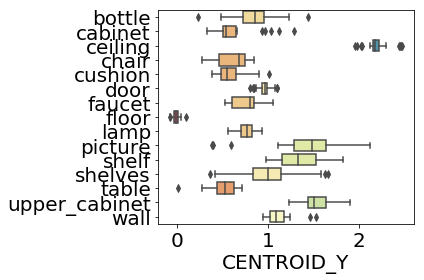

bottle
10
cabinet
11
ceiling
13
chair
10
cushion
12
door
11
faucet
10
floor
12
lamp
10
picture
10
shelf
11
shelves
12
table
12
upper_cabinet
12
wall
11
{'picture': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'ceiling': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'door': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'bottle': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'floor': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'wall': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'shelf': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'shelves': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'faucet': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'cabinet': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'upper_cabinet': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'lamp': (0.998077662437524, 0.9992310649750096, 0.746

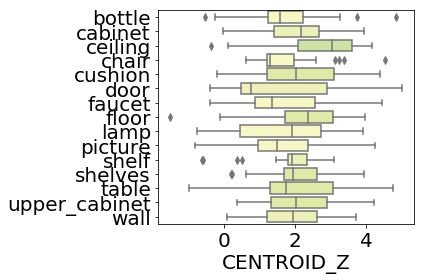

bottle
1
cabinet
1
ceiling
5
chair
1
cushion
1
door
1
faucet
1
floor
5
lamp
1
picture
1
shelf
1
shelves
1
table
1
upper_cabinet
1
wall
2
{'picture': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'ceiling': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'door': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'bottle': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'floor': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'wall': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'shelf': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'shelves': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'faucet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'cabinet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'upper_cabinet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'lamp': (0.8141484044598232, 0.2196847366397539, 0.3048058439061

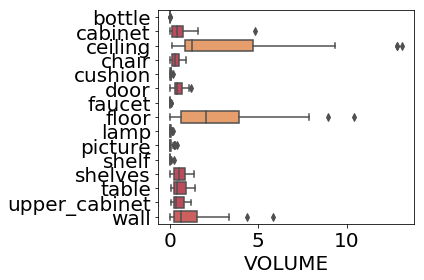

bottle
1
cabinet
1
ceiling
6
chair
1
cushion
1
door
1
faucet
1
floor
7
lamp
1
picture
1
shelf
1
shelves
1
table
1
upper_cabinet
1
wall
3
{'picture': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'ceiling': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'door': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'bottle': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'floor': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'wall': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'shelf': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'shelves': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'faucet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'cabinet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'upper_cabinet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'lamp': (0.8141484044598232, 0.2196847366397539, 0.304805843906

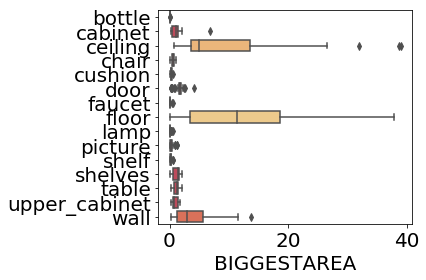

bottle
19
cabinet
19
ceiling
1
chair
15
cushion
8
door
20
faucet
13
floor
1
lamp
17
picture
18
shelf
3
shelves
18
table
5
upper_cabinet
16
wall
20
{'picture': (0.26405228758169935, 0.6091503267973857, 0.7098039215686275), 'ceiling': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'door': (0.2941945405613224, 0.4062283737024224, 0.680968858131488), 'bottle': (0.21299500192233756, 0.5114186851211072, 0.730795847750865), 'floor': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'wall': (0.2941945405613224, 0.4062283737024224, 0.680968858131488), 'shelf': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'shelves': (0.26405228758169935, 0.6091503267973857, 0.7098039215686275), 'faucet': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'cabinet': (0.21299500192233756, 0.5114186851211072, 0.730795847750865), 'upper_cabinet': (0.47427912341407163, 0.7898500576701268, 0.6459823144944252), 'lamp': (0.3600153787004998, 0.7161860822760476, 0.66

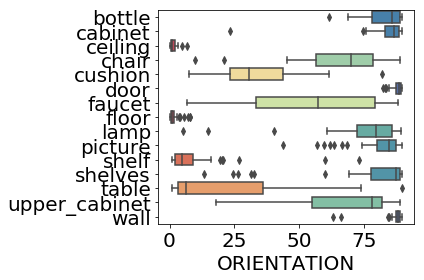

bottle
8
cabinet
6
ceiling
10
chair
9
cushion
8
door
3
faucet
9
floor
6
lamp
8
picture
9
shelf
8
shelves
9
table
7
upper_cabinet
7
wall
7
{'picture': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'ceiling': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'door': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'bottle': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'floor': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'wall': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'shelf': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'shelves': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'faucet': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'cabinet': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'upper_cabinet': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'lamp': (0.9963860053825452, 0.8879661668589004, 0.56109188773

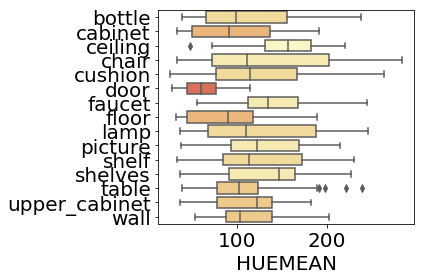

bottle
7
cabinet
10
ceiling
2
chair
11
cushion
8
door
14
faucet
4
floor
10
lamp
8
picture
5
shelf
7
shelves
8
table
9
upper_cabinet
6
wall
4
{'picture': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'ceiling': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'door': (0.7114186851211075, 0.8832756632064592, 0.6348327566320646), 'bottle': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'floor': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'wall': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'shelf': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'shelves': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'faucet': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'cabinet': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'upper_cabinet': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'lamp': (0.9963860053825452, 0.8879661668589004, 0.561091887

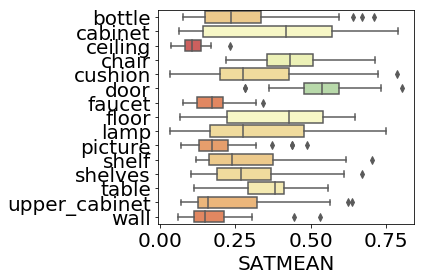

bottle
11
cabinet
9
ceiling
12
chair
6
cushion
11
door
7
faucet
9
floor
5
lamp
11
picture
12
shelf
8
shelves
8
table
7
upper_cabinet
11
wall
12
{'picture': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'ceiling': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'door': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'bottle': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'floor': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'wall': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'shelf': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'shelves': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'faucet': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'cabinet': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'upper_cabinet': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'lamp': (0.9557862360630527, 0.9823144944252211, 0.680046

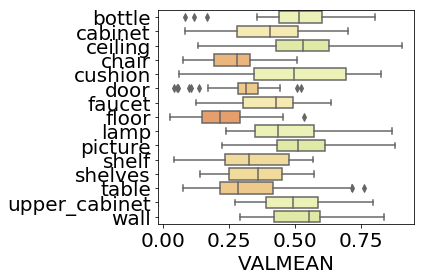

bottle
9
cabinet
10
ceiling
11
chair
10
cushion
12
door
10
faucet
13
floor
10
lamp
13
picture
11
shelf
11
shelves
13
table
12
upper_cabinet
13
wall
14
{'picture': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'ceiling': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'door': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'bottle': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'floor': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'wall': (0.7114186851211075, 0.8832756632064592, 0.6348327566320646), 'shelf': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'shelves': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'faucet': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'cabinet': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'upper_cabinet': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'lamp': (0.8202998846597465, 0.9275663206459055, 0.612

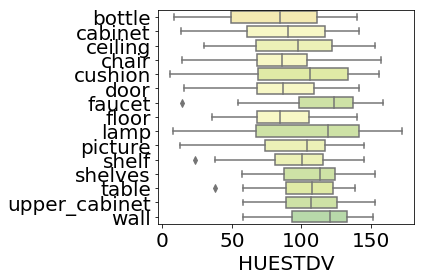

bottle
8
cabinet
10
ceiling
4
chair
12
cushion
8
door
13
faucet
6
floor
10
lamp
8
picture
7
shelf
8
shelves
10
table
10
upper_cabinet
8
wall
7
{'picture': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'ceiling': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'door': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'bottle': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'floor': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'wall': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'shelf': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'shelves': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'faucet': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'cabinet': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'upper_cabinet': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'lamp': (0.9963860053825452, 0.8879661668589004, 0.561091887

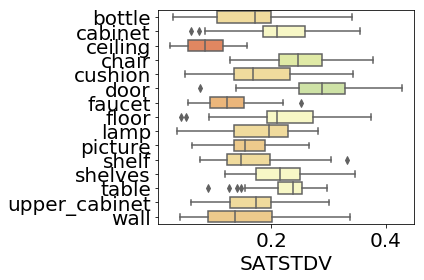

bottle
8
cabinet
9
ceiling
8
chair
9
cushion
10
door
10
faucet
9
floor
6
lamp
11
picture
11
shelf
8
shelves
11
table
10
upper_cabinet
11
wall
11
{'picture': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'ceiling': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'door': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'bottle': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'floor': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'wall': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'shelf': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'shelves': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'faucet': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'cabinet': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'upper_cabinet': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'lamp': (0.9557862360630527, 0.9823144944252211, 0.6800461

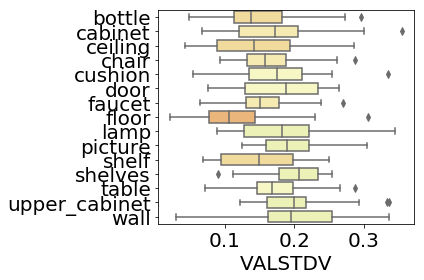

bottle
12
cabinet
14
ceiling
8
chair
11
cushion
12
door
17
faucet
11
floor
15
lamp
13
picture
11
shelf
11
shelves
12
table
13
upper_cabinet
13
wall
13
{'picture': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'ceiling': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'door': (0.3600153787004998, 0.7161860822760476, 0.6655132641291811), 'bottle': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'floor': (0.5910034602076126, 0.835524798154556, 0.6442906574394464), 'wall': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'shelf': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'shelves': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'faucet': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'cabinet': (0.7114186851211075, 0.8832756632064592, 0.6348327566320646), 'upper_cabinet': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'lamp': (0.8202998846597465, 0.9275663206459055, 0.6

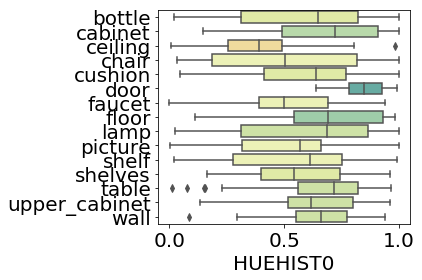

bottle
2
cabinet
1
ceiling
2
chair
1
cushion
2
door
1
faucet
1
floor
1
lamp
1
picture
2
shelf
1
shelves
1
table
1
upper_cabinet
1
wall
1
{'picture': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'ceiling': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'door': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'bottle': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'floor': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'wall': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'shelf': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'shelves': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'faucet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'cabinet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'upper_cabinet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'lamp': (0.8141484044598232, 0.2196847366397539, 0.30480584390

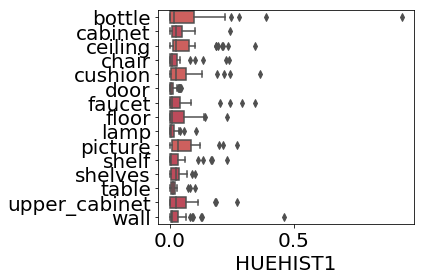

bottle
2
cabinet
3
ceiling
6
chair
2
cushion
2
door
1
faucet
3
floor
3
lamp
1
picture
4
shelf
2
shelves
2
table
2
upper_cabinet
3
wall
2
{'picture': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'ceiling': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'door': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'bottle': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'floor': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'wall': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'shelf': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'shelves': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'faucet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'cabinet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'upper_cabinet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'lamp': (0.8141484044598232, 0.2196847366397539, 0.304805

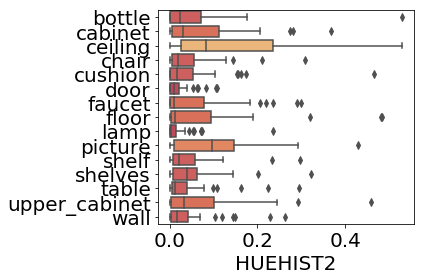

bottle
4
cabinet
3
ceiling
6
chair
7
cushion
3
door
2
faucet
4
floor
3
lamp
4
picture
5
shelf
6
shelves
5
table
5
upper_cabinet
3
wall
3
{'picture': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'ceiling': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'door': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'bottle': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'floor': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'wall': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'shelf': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'shelves': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'faucet': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'cabinet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'upper_cabinet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'lamp': (0.9665513264129182, 0.49742406766628217, 0.29504036

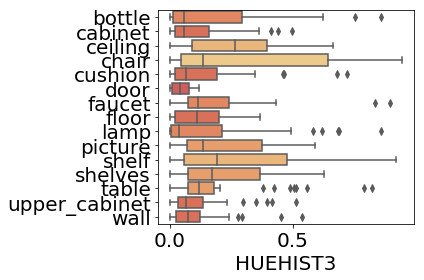

bottle
3
cabinet
3
ceiling
4
chair
3
cushion
5
door
2
faucet
5
floor
2
lamp
5
picture
3
shelf
3
shelves
4
table
3
upper_cabinet
4
wall
5
{'picture': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'ceiling': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'door': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'bottle': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'floor': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'wall': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'shelf': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'shelves': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'faucet': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'cabinet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'upper_cabinet': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'lamp': (0.9817762399077278, 0.6073817762399076, 0.34579008

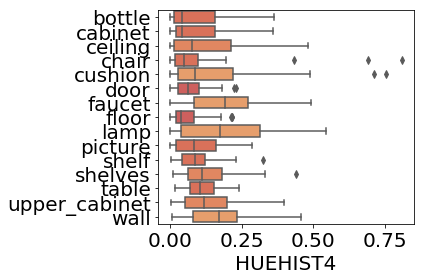

bottle
3
cabinet
6
ceiling
2
chair
9
cushion
5
door
8
faucet
4
floor
11
lamp
4
picture
3
shelf
6
shelves
7
table
8
upper_cabinet
3
wall
3
{'picture': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'ceiling': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'door': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'bottle': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'floor': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'wall': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'shelf': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'shelves': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'faucet': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'cabinet': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'upper_cabinet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'lamp': (0.9665513264129182, 0.49742406766628217, 0.295040

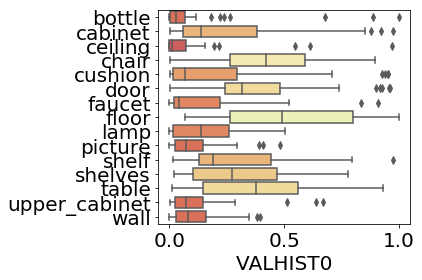

bottle
5
cabinet
7
ceiling
5
chair
7
cushion
4
door
8
faucet
8
floor
7
lamp
6
picture
5
shelf
8
shelves
6
table
7
upper_cabinet
6
wall
5
{'picture': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'ceiling': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'door': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'bottle': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'floor': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'wall': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'shelf': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'shelves': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'faucet': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'cabinet': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'upper_cabinet': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'lamp': (0.9928489042675894, 0.716955017301038, 0.4094579008073

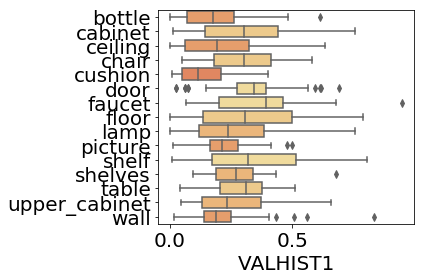

bottle
9
cabinet
6
ceiling
8
chair
5
cushion
6
door
5
faucet
8
floor
3
lamp
7
picture
7
shelf
6
shelves
6
table
5
upper_cabinet
7
wall
7
{'picture': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'ceiling': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'door': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'bottle': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'floor': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'wall': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'shelf': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'shelves': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'faucet': (0.9963860053825452, 0.8879661668589004, 0.5610918877354863), 'cabinet': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'upper_cabinet': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'lamp': (0.9946943483275663, 0.8092272202998846, 0.4869665513

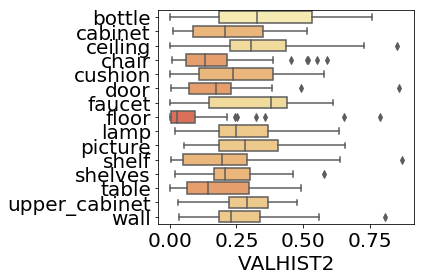

bottle
7
cabinet
4
ceiling
6
chair
2
cushion
6
door
2
faucet
3
floor
1
lamp
4
picture
6
shelf
3
shelves
4
table
3
upper_cabinet
6
wall
7
{'picture': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'ceiling': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'door': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'bottle': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'floor': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'wall': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'shelf': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'shelves': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'faucet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'cabinet': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'upper_cabinet': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'lamp': (0.9665513264129182, 0.49742406766628217, 0.29504036

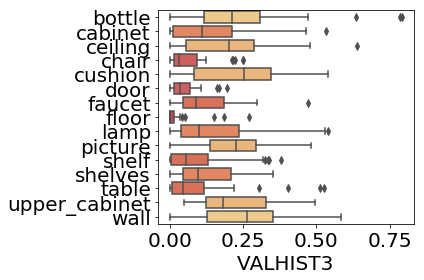

bottle
3
cabinet
2
ceiling
4
chair
1
cushion
4
door
1
faucet
2
floor
1
lamp
4
picture
4
shelf
1
shelves
2
table
2
upper_cabinet
3
wall
4
{'picture': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'ceiling': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'door': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'bottle': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'floor': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'wall': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'shelf': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'shelves': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'faucet': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'cabinet': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'upper_cabinet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'lamp': (0.9665513264129182, 0.49742406766628217, 0.29504036

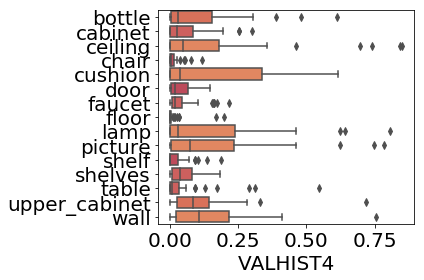

bottle
11
cabinet
9
ceiling
18
chair
6
cushion
9
door
4
faucet
14
floor
7
lamp
10
picture
13
shelf
10
shelves
10
table
7
upper_cabinet
12
wall
15
{'picture': (0.8202998846597465, 0.9275663206459055, 0.6126874279123413), 'ceiling': (0.26405228758169935, 0.6091503267973857, 0.7098039215686275), 'door': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'bottle': (0.9557862360630527, 0.9823144944252211, 0.6800461361014996), 'floor': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'wall': (0.5910034602076126, 0.835524798154556, 0.6442906574394464), 'shelf': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'shelves': (0.998077662437524, 0.9992310649750096, 0.7460207612456747), 'faucet': (0.7114186851211075, 0.8832756632064592, 0.6348327566320646), 'cabinet': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'upper_cabinet': (0.9096501345636295, 0.9638600538254518, 0.6080738177623992), 'lamp': (0.998077662437524, 0.9992310649750096, 0.7460207

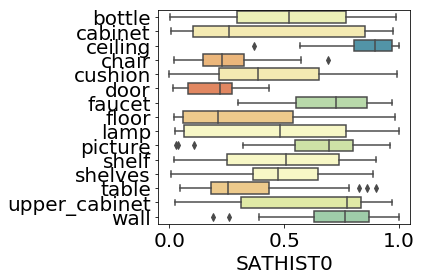

bottle
7
cabinet
3
ceiling
4
chair
6
cushion
6
door
5
faucet
6
floor
5
lamp
5
picture
6
shelf
7
shelves
6
table
8
upper_cabinet
5
wall
4
{'picture': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'ceiling': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'door': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'bottle': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'floor': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'wall': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'shelf': (0.9946943483275663, 0.8092272202998846, 0.48696655132641287), 'shelves': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'faucet': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'cabinet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'upper_cabinet': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'lamp': (0.9817762399077278, 0.6073817762399076, 0.34579008073

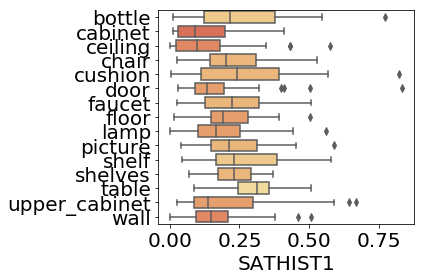

bottle
3
cabinet
4
ceiling
1
chair
6
cushion
4
door
5
faucet
2
floor
5
lamp
5
picture
3
shelf
3
shelves
4
table
5
upper_cabinet
3
wall
2
{'picture': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'ceiling': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'door': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'bottle': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'floor': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'wall': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'shelf': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'shelves': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'faucet': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'cabinet': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'upper_cabinet': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'lamp': (0.9817762399077278, 0.6073817762399076, 0.34579008

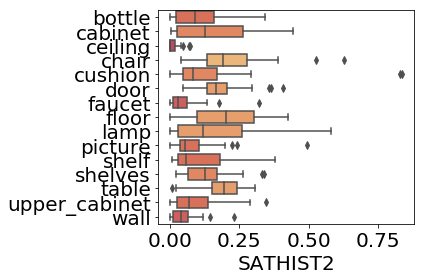

bottle
2
cabinet
5
ceiling
1
chair
5
cushion
3
door
6
faucet
1
floor
5
lamp
4
picture
1
shelf
3
shelves
3
table
4
upper_cabinet
2
wall
1
{'picture': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'ceiling': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'door': (0.9928489042675894, 0.716955017301038, 0.40945790080738165), 'bottle': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'floor': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'wall': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'shelf': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'shelves': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'faucet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'cabinet': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'upper_cabinet': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'lamp': (0.9665513264129182, 0.49742406766628217, 0.295040369

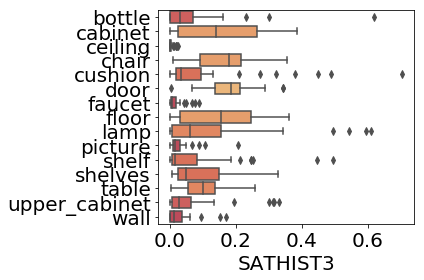

bottle
2
cabinet
5
ceiling
1
chair
4
cushion
3
door
9
faucet
1
floor
4
lamp
3
picture
1
shelf
2
shelves
3
table
3
upper_cabinet
2
wall
1
{'picture': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'ceiling': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'door': (0.9982314494425221, 0.9451749327181853, 0.6570549788542868), 'bottle': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'floor': (0.9665513264129182, 0.49742406766628217, 0.295040369088812), 'wall': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'shelf': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'shelves': (0.9330257593233372, 0.3913110342176086, 0.27197231833910035), 'faucet': (0.8141484044598232, 0.2196847366397539, 0.3048058439061899), 'cabinet': (0.9817762399077278, 0.6073817762399076, 0.3457900807381776), 'upper_cabinet': (0.8758169934640523, 0.3045751633986928, 0.29411764705882354), 'lamp': (0.9330257593233372, 0.3913110342176086, 0.2719723183

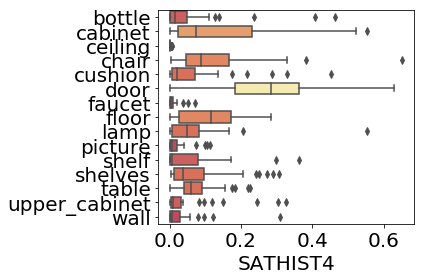

In [7]:
# VISUALIZATION
#
utils.plot_variables_description(data, config)

In [8]:
# Turn predictors into categorical vbles for chi-square test
utils.turn_vbles_to_categorical(data, config["vbles_to_work_with"], config)
chi2 = [[], []]

for vble in config["vbles_to_work_with"]:
    ct1 = pandas.crosstab(data[config["gt_vble"]], data[vble + '_C'])
    print str(vble) + '_C: chi-square value, p value, expected counts'
    cs1 = scipy.stats.chi2_contingency(ct1)
    chi2[0].append(cs1[0])
    chi2[1].append(vble)
    print cs1

PLANARITY_C: chi-square value, p value, expected counts
(93.11232813516573, 9.769368398421293e-14, 14, array([[18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.46748682, 18.53251318],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192]]))
SCATTER_C: chi-square value, p value, expected counts
(137.74404493643502, 1.991286105283114e-22, 14, array([[18.46748682, 18.53251318],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19

VALSTDV_C: chi-square value, p value, expected counts
(61.4536243765907, 6.512704437433397e-08, 14, array([[18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.46748682, 18.53251318],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192]]))
HUEHIST0_C: chi-square value, p value, expected counts
(79.47928460433434, 3.533844615154817e-11, 14, array([[18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.96660808, 19.03339192],
       [18.46748682, 18.53251318],
       [18.96660808, 19.03

SATHIST4_C: chi-square value, p value, expected counts
(168.1079789173159, 1.650367734742017e-28, 14, array([[14.07471264, 16.92528736],
       [17.25287356, 20.74712644],
       [11.35057471, 13.64942529],
       [17.25287356, 20.74712644],
       [16.79885057, 20.20114943],
       [17.25287356, 20.74712644],
       [12.25862069, 14.74137931],
       [15.8908046 , 19.1091954 ],
       [14.52873563, 17.47126437],
       [15.8908046 , 19.1091954 ],
       [16.34482759, 19.65517241],
       [17.25287356, 20.74712644],
       [17.25287356, 20.74712644],
       [17.25287356, 20.74712644],
       [16.34482759, 19.65517241]]))


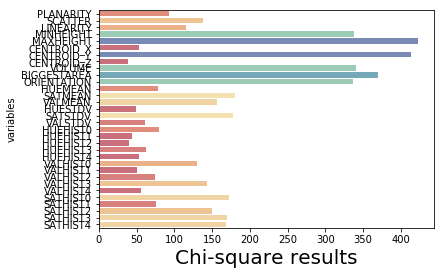

In [9]:
# VISUALIZATION 
utils.plot_chi_square_values(chi2, config)

## Second step: preprocessing


In [10]:
if config["standarized_features"]:
    # Standardize variables to have mean=0 and sd=1
    for vble in config["vbles_to_work_with"]:
        data[vble] = preprocessing.scale(data[vble].astype('float64'))

## Third step: model fitting and evaluation

Obtaining metrics for.. Logistic.. SVM.. GaussianNaiveBayes..

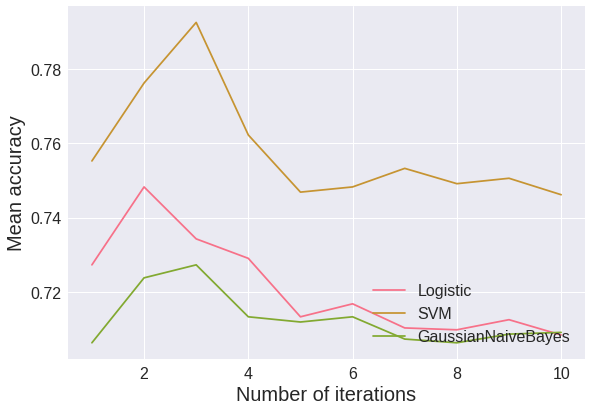

In [15]:
# Prepare predictor and ground truth variables
data_X = data[config["vbles_to_work_with"]]
data_y = data[config["gt_vble"]]

# Compute the performance of each model
models = [{'name': 'Logistic', 'clf': linear_model.LogisticRegression(), 'statistics': utils.statistics()},
          #{'name': 'DecisionTree', 'clf': tree.DecisionTreeClassifier(), 'statistics': utils.statistics()},
          #{'name': 'RandomForest', 'clf': RandomForestClassifier(), 'statistics': utils.statistics()},
          #{'name': 'ExtraTrees', 'clf': ExtraTreesClassifier(), 'statistics': utils.statistics()},
          {'name': 'SVM', 'clf': svm.SVC(kernel='linear'), 'statistics': utils.statistics()},
          #{'name': 'KNeighbors', 'clf': KNeighborsClassifier(), 'statistics': utils.statistics()},
          {'name': 'MLP', 'clf': MLPClassifier(alpha=1), 'statistics': utils.statistics()},
          {'name': 'GaussianProcess', 'clf': GaussianProcessClassifier(1.0 * RBF(1.0)), 'statistics': utils.statistics()},
          {'name': 'GaussianNaiveBayes', 'clf': GaussianNB(), 'statistics': utils.statistics()},
          {'name': 'QDA', 'clf': QuadraticDiscriminantAnalysis(), 'statistics': utils.statistics()},
          {'name': 'AdaBoost', 'clf': AdaBoostClassifier(), 'statistics': utils.statistics()},
          {'name': 'GradientBoosting', 'clf': GradientBoostingClassifier(), 'statistics': utils.statistics()}
          ]

accumulated_cnf_matrix = np.zeros(shape=(config["n_object_categories"], config["n_object_categories"]), dtype=int)

print 'Obtaining metrics for..',

for model in models:

    if model['name'] in config["models_to_work_with"]:

        seaborn.set_palette(seaborn.color_palette("husl", len(config["models_to_work_with"])))

        print model['name'] + '..',

        for try_i in range(0, config["cross_validation_n_iterations"]):

            test_size = 1. / config["cross_validation_n_folds"]
            X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=test_size)
            model['clf'].fit(X_train, y_train)
            y_pred = model['clf'].predict(X_test)

            model['statistics'].accuracy.append(metrics.accuracy_score(y_test, y_pred))
            model['statistics'].macro_precision.append(metrics.precision_score(y_test, y_pred, average='macro'))
            model['statistics'].macro_recall.append(metrics.recall_score(y_test, y_pred, average='macro'))
            model['statistics'].f1_score.append(metrics.f1_score(y_test, y_pred, average='micro'))

            model['statistics'].partial_accuracy.append(np.mean(model['statistics'].accuracy))
            model['statistics'].partial_macro_precision.append(np.mean(model['statistics'].macro_precision))
            model['statistics'].partial_f1_score.append(np.mean(model['statistics'].f1_score))

            if config["confusion_matrix_show_method"]:
                cnf_matrix = confusion_matrix(y_test, y_pred)
                accumulated_cnf_matrix = np.add(accumulated_cnf_matrix, cnf_matrix)

        utils.plot_partial_cross_validation_results(range=range(1, config["cross_validation_n_iterations"] + 1),
                                                    metric=model['statistics'].partial_f1_score,
                                                    label=model['name'])

# VISUALIZATION
utils.plot_cross_validation(config)

Confusion matrix, without normalization


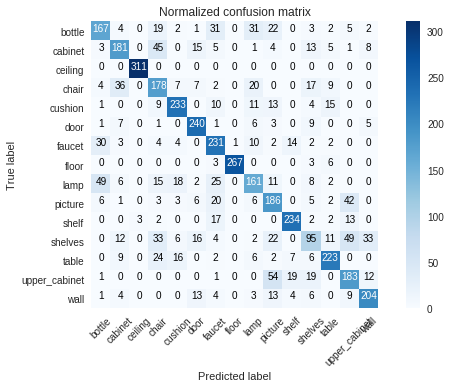

Normalized confusion matrix


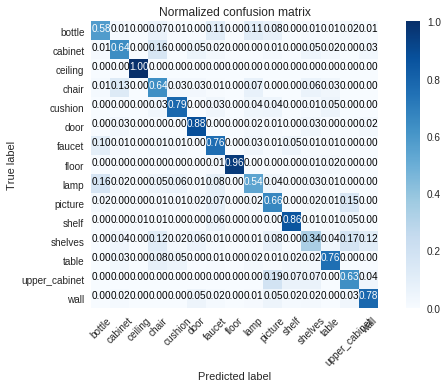

In [19]:
# VISUALIZATION

# Show confusion matrix
utils.plot_confusion_matrix(accumulated_cnf_matrix, classes=sorted(c2.index[0:config["n_object_categories"]]),
                                normalize=False,
                                title='Normalized confusion matrix')
utils.plot_confusion_matrix(accumulated_cnf_matrix, classes=sorted(c2.index[0:config["n_object_categories"]]),
                                normalize=True,
                                title='Normalized confusion matrix')

Testing models with different number of features:  32.. 31.. 30.. 29.. 28.. 27.. 26.. 25.. 24.. 23.. 22.. 21.. 20.. 19.. 18.. 17.. 16.. 15.. 14.. 13.. 12.. 11.. 10.. 9.. 8.. 7.. 6.. 5.. 4.. 3.. 2.. 1..

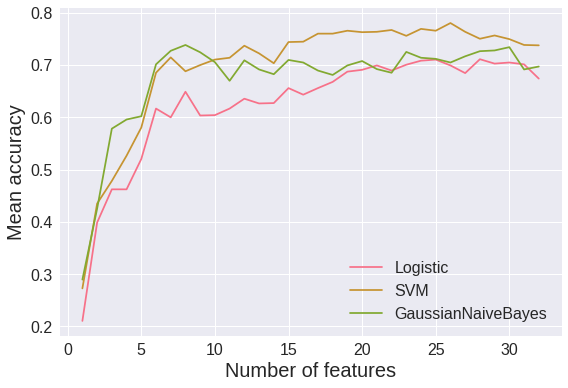

In [20]:
# VISUALIZATION
# Show the models performance using a different sets of features
utils.plot_performance_with_sets_of_features(models, chi2, data, config)